# Creating a Kaggle Workflow

## Introduction

Data science, and particularly machine learning, contain many dimensions of complexity when compared with standard software development. In standard software development, code not working as you expect can be caused by a number of factors along two dimensions:
- Bugs in implementation
- Algorithm design

Machine learning problems, have many more dimensions:
- Bugs in implementation
- Algorithm design
- Model issues
- Data quality

The result of this is that there are exponentially more places that machine learning can go wrong.

**By defining a workflow for yourself, you can give yourself a framework with which to make iterating on ideas quicker and easier, allowing yourself to work more efficiently.**

In this mission, we're going to explore a workflow to make competing in the [**Kaggle Titanic competition**](https://www.kaggle.com/c/titanic) easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.

## Importing packages and Reading files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_columns = 999

In [2]:
train = pd.read_csv("my_datasets/train.csv")
holdout = pd.read_csv("my_datasets/test.csv")

print("train shape:", train.shape)
print("holdout shape:", holdout.shape)

holdout.head()

train shape: (891, 12)
holdout shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Importing external files

We can use one of those magic commands, the %load command, to load an external file. The %load command will copy the contents of the file into the current notebook cell.

We can import the "functions.py" file, with the functions created during "Kaggle Fundamentals" course.

In [3]:
# %load my_datasets/functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

## Preprocessing the Data

In [4]:
# Function to apply clean and prepare a DataFrame using the previous functions
def prepare_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    columns = ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]
    for c in columns:
        df = create_dummies(df, c)
    return df

In [5]:
train = prepare_df(train)
holdout = prepare_df(holdout)

print("train shape:", train.shape)
print("holdout shape:", holdout.shape)

holdout.head()

train shape: (891, 43)
holdout shape: (418, 41)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Adult,0-12,Mrs,Unknown,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Senior,0-12,Mr,Unknown,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,Young Adult,12-50,Mrs,Unknown,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0


## Exploring the Data

The Kaggle workflow we are going to build will combine all of these into a process:
- **Data exploration**, to find patterns in the data
- **Feature engineering**, to create new features from those patterns or through pure experimentation
- **Feature selection**, to select the best subset of our current set of features
- **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then **Submit to Kaggle** to get a leaderboard score.

Let's explore the columns "SibSp" and "Parch":
 - **SibSp**: Number of Siblings/Spouses aboard the Titanic
 - **Parch**: Number of Parents/Children aboard the Titanic

In [6]:
explore_cols = ["SibSp","Parch"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

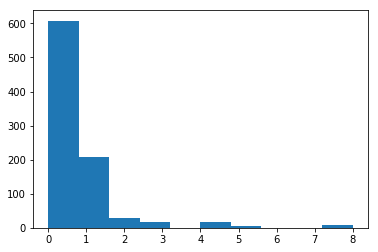

In [7]:
# Values for SibSp
print(explore["SibSp"].value_counts())
plt.hist(explore["SibSp"])

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


(array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

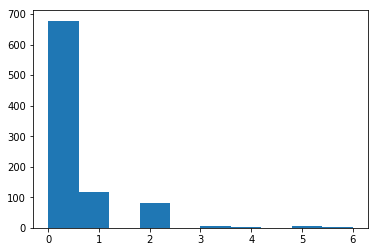

In [8]:
# Values for Parch
print(explore["Parch"].value_counts())
plt.hist(explore["Parch"])

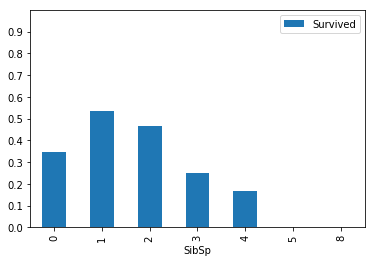

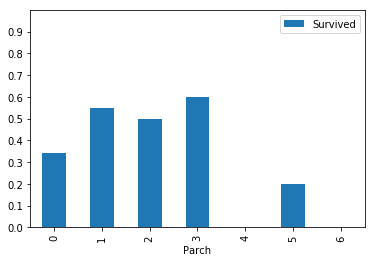

In [9]:
#Proportion of survivals depending on "SibSp" and "Parch" values
for c in explore_cols:
    pivot = train.pivot_table(index=c, values="Survived")
    pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,.1))
    plt.show()

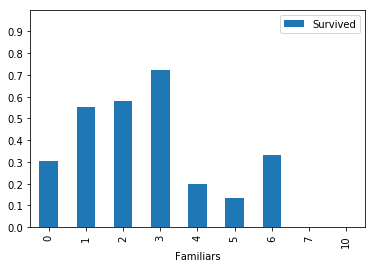

In [10]:
# Find a way to combine the columns
explore["Familiars"] = explore[explore_cols].sum(axis=1)
explore["Survived"] = train["Survived"].copy()
pivot = explore.pivot_table(index="Familiars", values="Survived")
pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,.1))
plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

## Engineering New Features

Based on the previous results, we can come up with an idea for a new feature - "was the passenger alone?". This will be a binary column containing the value:
- **1** if the passenger has zero family members onboard
- **0** if the passenger has one or more family members onboard

In [11]:
def process_family(df):
    familiars = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[familiars==0,"isalone"] = 1
    return df

In [12]:
train = process_family(train)
holdout = process_family(holdout)

## Selecting the Best-Performing Features

To speed up our Kaggle workflow, we can create a function that performs this step for us, which will mean we can perform feature selection by calling a self-contained function and focus our efforts on the more creative part - exploring the data and engineering new features.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    df = df.select_dtypes(include=[np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    rf = RandomForestClassifier(random_state=1, n_estimators=10)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print(best_columns)
    
    return best_columns

In [14]:
best_cols = select_features(train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


## Selecting and Tuning Different Algorithms

Just like we did with feature selection, we can can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:
- The name of the particular model
- An estimator object for the model
- A dictionary of hyperparameters that we'll use for grid search.

We can then use a for loop to iterate over the list of dictionaries, and for each one we can use scikit-learn's **model_selection.GridSearchCV** class to find the best set of performing parameters, and add values for both the parameter set and the score to the dictionary.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [16]:
models = select_model(train, best_cols)

LogisticRegression
------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score: 0.7755331088664422
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8294051627384961
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4}



## Making a Submission to Kaggle

If you're going to be continually submitting to Kaggle, a function will help make this easier. Let's create a function to automate this.

In [18]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission = pd.DataFrame(
        {
            "PassengerId": holdout_ids,
            "Survived": predictions
        }
    )
    submission.to_csv(filename,index=False)

#models[2] because it refers to RandomForestClassifier: the model with highest score
best_rf_model = models[2]["best_model"]
save_submission_file(best_rf_model,best_cols)